# xRFI explorative tests

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
%matplotlib notebook

import matplotlib.pyplot as plt

from edges_cal import xrfi

In [2]:
NFREQ = 1000
freq = np.linspace(50, 150, NFREQ)

In [3]:
p = np.poly1d([1750, 0, 3, -2, 7, 5][::-1])
f = np.linspace(-1, 1, len(freq))
sky_model = (freq / 75.0) ** -2.55 * p(f)

In [11]:
rfi_model = np.zeros(NFREQ)
# rfi_model[::50] = 1

In [5]:
def thermal_noise(spec, scale=1, seed=None):
    if seed:
        np.random.seed(seed)
    return np.random.normal(0, spec / scale)

In [6]:
scale = 1000
amplitude = 50

In [12]:
std = sky_model/scale
amp = std.max() * amplitude
noise = thermal_noise(sky_model, scale=scale, seed=1010)
rfi = rfi_model * amp
sky = sky_model + noise + rfi

<IPython.core.display.Javascript object>


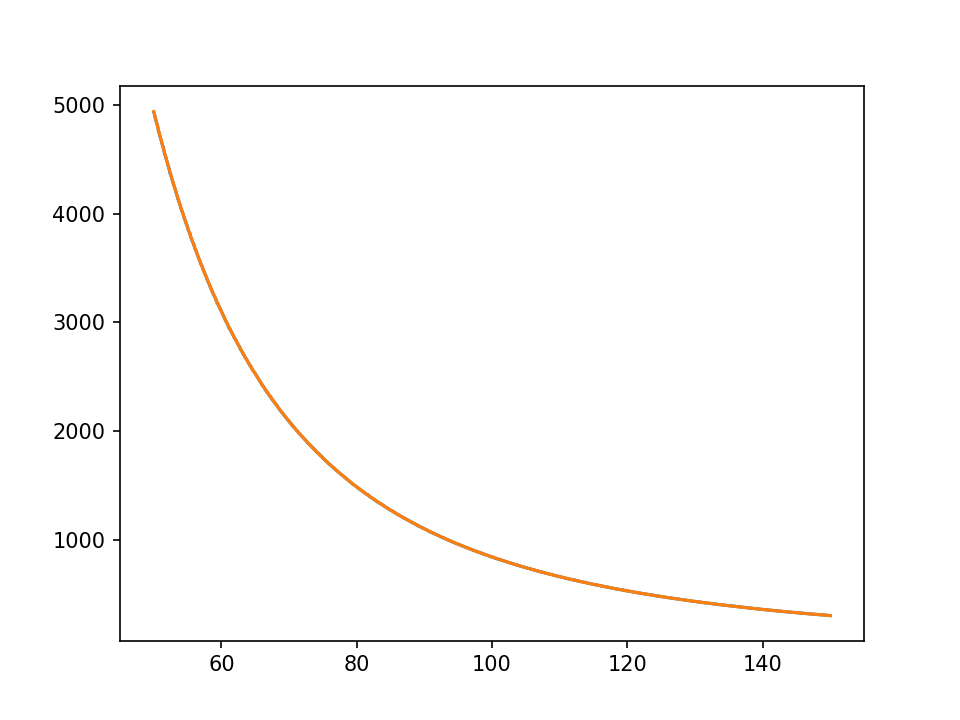

In [22]:
plt.plot(freq, sky)
plt.plot(freq, sky_model)

In [33]:
sig = xrfi.detrend_medfilt(sky, half_size=(8,))

(17,)


In [36]:
from scipy.signal import medfilt

In [84]:
f = np.linspace(0, 1, len(sky))
resid = sky - xrfi.ModelFit('polynomial', f, sky, n_terms=3).evaluate()

Polynomial


<IPython.core.display.Javascript object>


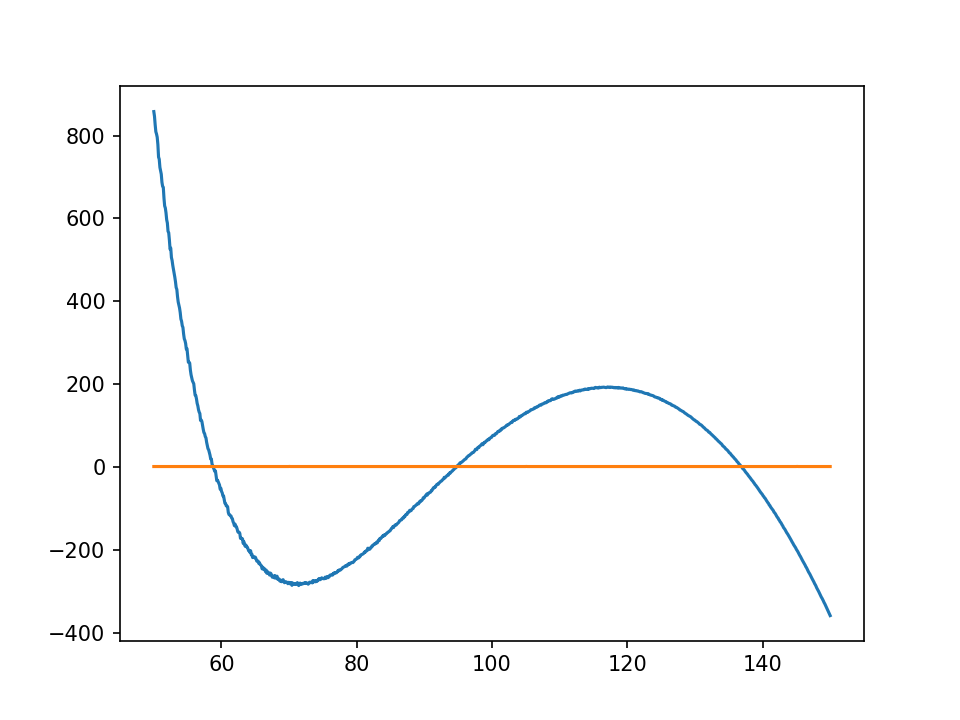

In [85]:
plt.plot(freq, resid)

In [86]:
size=5
d_sm = xrfi.flagged_median_filter(resid, size=(size,))
d_rs = sky - d_sm
d_sq = d_rs ** 2
sigma = np.sqrt(xrfi.flagged_median_filter(d_sq, size=(size,)) / 0.456)
significance = xrfi.robust_divide(d_rs, sigma)
flags = np.abs(significance) > 10

<IPython.core.display.Javascript object>


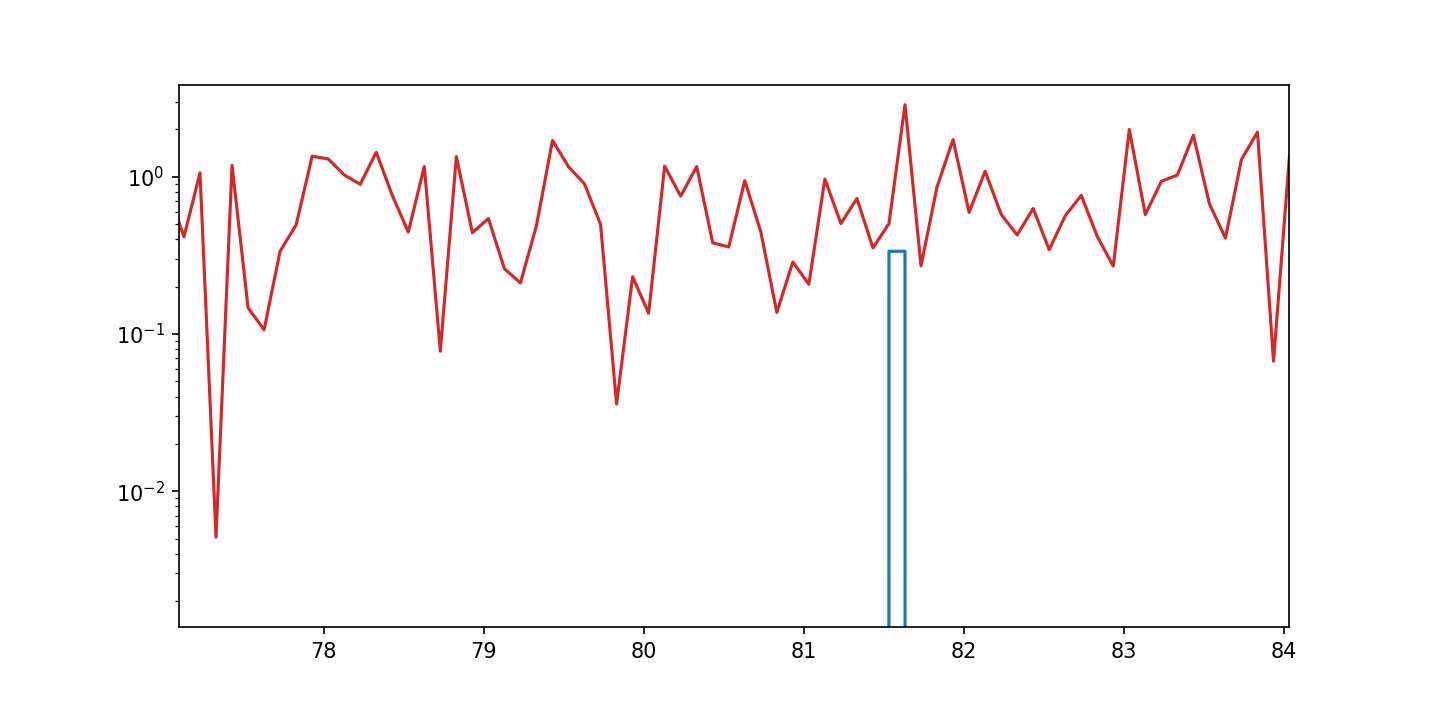

In [67]:
plt.plot(freq, np.abs(d_rs))
plt.plot(freq, sigma)
plt.plot(freq, significance)
plt.plot(freq, np.abs((sky - sky_model)) / std)
plt.yscale('log')

In [87]:
np.any(flags), np.where(flags)[0]

(False, array([], dtype=int64))

In [72]:
d_rs[313:319]

array([ 0.        ,  0.        , -0.33549046,  0.33549046,  0.        ,
        0.        ])

In [64]:
flags, sig = xrfi.xrfi_medfilt(sky, kf=1)

(3,)


In [65]:
np.any(flags)

False

In [21]:
np.where(flags)

(array([  0,   1,   2,   3, 315, 316, 374, 375, 512, 513, 549, 550, 586,
        587, 595, 596, 641, 642, 651, 652, 657, 658, 685, 686, 697, 698,
        730, 731, 743, 744, 751, 752, 757, 758, 765, 766, 771, 772, 801,
        802, 820, 821, 845, 846, 850, 851, 870, 871, 900, 901, 902, 903,
        909, 910, 916, 918, 921, 922, 923, 924, 925, 926, 935, 936, 963,
        964, 967, 968, 976, 977, 986, 987, 990, 991, 992, 993, 994, 995,
        997, 998, 999]),)

### Uniform spectrum, regular RFI

In [88]:
sky_model = np.ones(NFREQ)
rfi_model = np.zeros(NFREQ)
rfi_model[50::50] = 1

rfi = rfi_model * 0.2
noise = thermal_noise(sky_model, scale=1000)
sky = rfi + noise + sky_model
true_flags = rfi_model > 0

In [121]:
spectrum = sky
kf = 5
max_iter = 1
use_meanfilt = True
poly_order = 0
inplace = False
flags = None
threshold = 6
accumulate = False

# ------
iter = 0

if flags is None:
    new_flags = np.zeros(spectrum.shape, dtype=bool)
else:
    new_flags = flags if inplace else flags.copy()

nflags = -1

resid = spectrum.copy()

size = (kf,) if spectrum.ndim == 1 else (kt, kf)
while iter < max_iter and np.sum(new_flags) > nflags:
    nflags = np.sum(new_flags)

    if spectrum.ndim == 1 and poly_order:
        f = np.linspace(0, 1, len(spectrum))
        resid[~new_flags] = (
            spectrum[~new_flags]
            - ModelFit(
                "polynomial",
                f[~new_flags],
                spectrum[~new_flags],
                n_terms=poly_order,
            ).evaluate()
        )
    else:
        resid = spectrum

    significance_med = xrfi.detrend_medfilt(resid, half_size=size, flags=new_flags)
    medfilt_flags = np.abs(significance_med) > threshold

    if use_meanfilt:
        significance = xrfi.detrend_meanfilt(resid, half_size=size, flags=medfilt_flags)

    if accumulate:
        new_flags |= np.abs(significance) > threshold
    else:
        new_flags = np.abs(significance) > threshold

    iter += 1

if 1 < max_iter == iter and np.sum(new_flags) > nflags:
    warnings.warn("Median filter reached max_iter and is still finding new RFI.")

In [122]:
data = resid

# --------------

# Meanfilt function

full_size = tuple(2 * s + 1 for s in size)

d_sm = xrfi.flagged_filter(data, size=full_size, kind='mean', flags=medfilt_flags)
d_rs = data - d_sm
d_sq = d_rs ** 2

# Factor of .456 is to put mod-z scores on same scale as standard deviation.
sig = np.sqrt(xrfi.flagged_filter(d_sq, size=full_size, kind='mean', flags=medfilt_flags))

# don't divide by zero, instead turn those entries into +inf
mean_sig = xrfi.robust_divide(d_rs, sig)

In [127]:
print("False positives: ", np.sum(medfilt_flags[~flags]))
print("False negatives: ", np.sum(~medfilt_flags[flags]))

False positives:  6
False negatives:  0


<IPython.core.display.Javascript object>


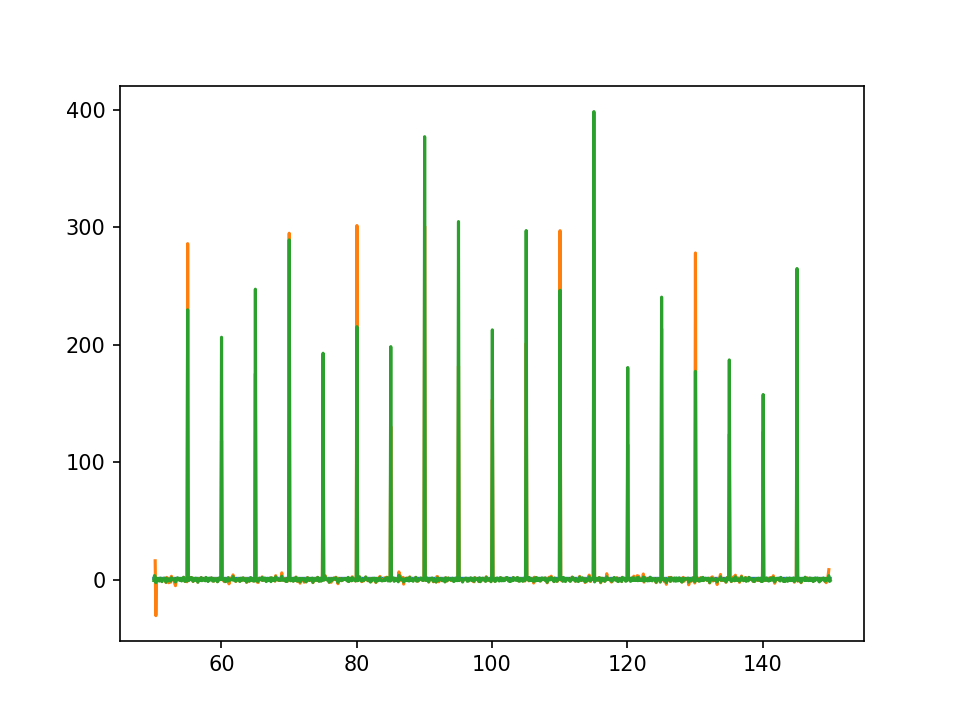

In [128]:
plt.plot(freq, sky)
plt.plot(freq, significance_med)
plt.plot(freq, significance)

In [131]:
print("False positives after medfilt: ", np.sum(medfilt_flags[~true_flags]))
print("False negatives after medfilt: ", np.sum(~medfilt_flags[true_flags]))
print("False positives after meanfilt: ", np.sum(new_flags[~true_flags]))
print("False negatives after meanfilt: ", np.sum(~new_flags[true_flags]))


False positives after medfilt:  6
False negatives after medfilt:  0
False positives after meanfilt:  0
False negatives after meanfilt:  0


## Poly

### Flat sky

In [156]:
sky_model = np.ones(NFREQ)
rfi_model = np.zeros(NFREQ)
rfi_model[50::50] = 1

rfi = rfi_model * 0.2
noise = thermal_noise(sky_model, scale=1000)
sky = rfi + noise + sky_model
true_flags = rfi_model > 0

In [165]:
spectrum = sky
weights=None
f_ratio=None
f_log=False
t_log=True,
n_signal=None
n_resid=3
n_abs_resid_threshold=5
max_iter=4
accumulate=False

# ------------

if f_log and not f_ratio:
    raise ValueError("If fitting in log(freq), you must provide f_ratio.")

assert n_abs_resid_threshold > 1.5


nf = spectrum.shape[-1]
orig_flags = np.zeros(nf, dtype=bool)
f = np.linspace(-1, 1, nf) if not f_log else np.logspace(0, f_ratio, nf)

orig_flags |= (spectrum <= 0) | np.isnan(spectrum) | np.isinf(spectrum)

if weights is not None:
    orig_flags |= weights <= 0

flags = orig_flags.copy()

if n_signal is None:
    n_signal = 2
    do_increase = True
else:
    do_increase = False
    assert n_resid < n_signal

n_flags = np.sum(flags)
n_flags_new = n_flags + 1
counter = 0
while (
    n_flags < n_flags_new
    and counter < max_iter
    and (nf - n_flags_new) > n_signal * 2
):
    n_flags = 1 * n_flags_new

    ff = f[~flags]
    s = spectrum[~flags]

    if t_log:
        s = np.log(s)

    par = np.polyfit(ff, s, n_signal)
    model = np.polyval(par, f)

    if t_log:
        model = np.exp(model)
        s = np.exp(s)
        
    res = spectrum - model

    par = np.polyfit(ff, np.abs(res[~flags]), n_resid)
    model_std = np.polyval(par, f)

    if accumulate:
        flags[~flags] |= np.abs(res)[~flags] > n_abs_resid_threshold * model_std[~flags]
    else:
        flags = orig_flags | (np.abs(res) > n_abs_resid_threshold * model_std)

    print(f"False positives after {counter+1} iters: ", np.sum(flags[~true_flags]))
    print(f"False negatives after {counter+1} iters: ", np.sum(~flags[true_flags]))
    
    n_flags_new = np.sum(flags)
    counter += 1
    if do_increase:
        n_signal += 1

False positives after 1 iters:  0
False negatives after 1 iters:  0
False positives after 2 iters:  0
False negatives after 2 iters:  0


### PL Sky

In [166]:
def sky_pl_1d(freq):
    return 1750 * (freq / 75.0) ** -2.55

In [194]:
sky_model = sky_pl_1d(freq)
rfi_model = np.zeros(NFREQ)
#rfi_model[50::50] = 1


noise = thermal_noise(sky_model, scale=1000)
rfi = rfi_model * (sky_model/1000).max() * 200
sky = rfi + noise + sky_model
true_flags = rfi_model > 0

<IPython.core.display.Javascript object>


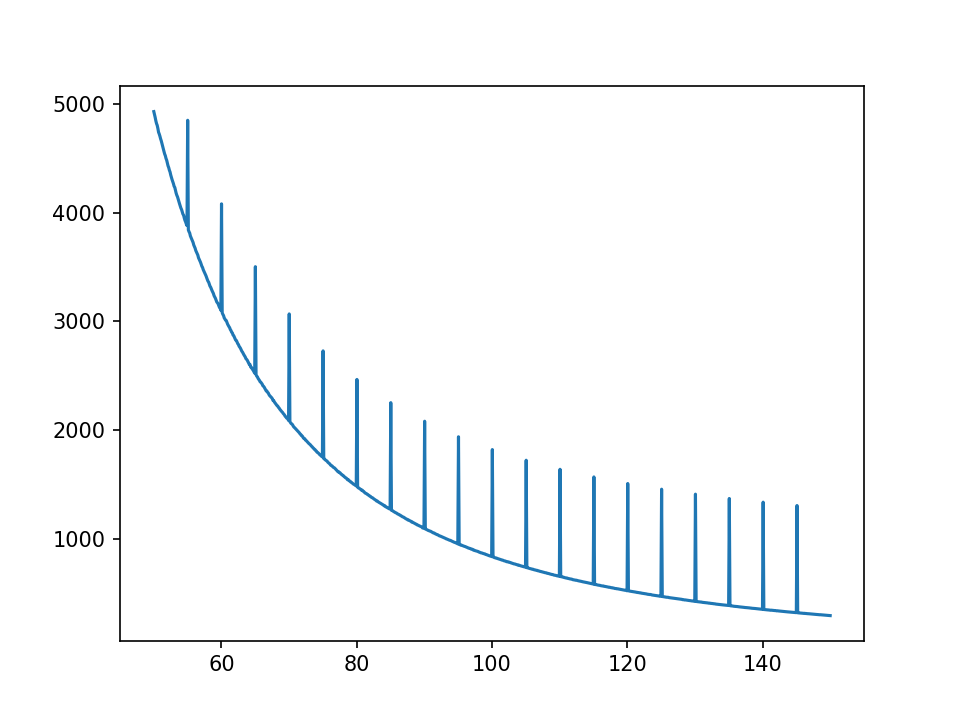

In [171]:
plt.plot(freq, sky)

In [201]:
spectrum = sky
weights=None
f_ratio=None
f_log=False
t_log=True,
n_signal=2
n_resid=3
n_abs_resid_threshold=10
max_iter=20
accumulate=False
do_increase=True

# ------------

if f_log and not f_ratio:
    raise ValueError("If fitting in log(freq), you must provide f_ratio.")

assert n_abs_resid_threshold > 1.5


nf = spectrum.shape[-1]
orig_flags = np.zeros(nf, dtype=bool)
f = np.linspace(-1, 1, nf) if not f_log else np.logspace(0, f_ratio, nf)

orig_flags |= (spectrum <= 0) | np.isnan(spectrum) | np.isinf(spectrum)

if weights is not None:
    orig_flags |= weights <= 0

flags = orig_flags.copy()

if not do_increase:
    assert n_resid < n_signal

n_flags_changed = 1
counter = 0
while (
    n_flags_changed > 0
    and counter < max_iter
    and np.sum(~flags) > n_signal * 2
):
    n_flags = 1 * n_flags_new

    ff = f[~flags]
    s = spectrum[~flags]

    if t_log:
        s = np.log(s)

    par = np.polyfit(ff, s, n_signal)
    model = np.polyval(par, f)

    if t_log:
        model = np.exp(model)
        s = np.exp(s)
        
    res = spectrum - model

    par = np.polyfit(ff, np.abs(res[~flags]), n_resid)
    model_std = np.polyval(par, f)

    if accumulate:
        nflags = np.sum(flags[~flags])
        flags[~flags] |= np.abs(res)[~flags] > n_abs_resid_threshold * model_std[~flags]
        n_flags_changed = np.sum(flags[~flags]) - nflags
    else:
        
        new_flags = orig_flags | (np.abs(res) > n_abs_resid_threshold * model_std)
        n_flags_changed = np.sum(flags ^ new_flags)
        flags = new_flags.copy()
        
    print(f"False positives after {counter+1} iters: ", np.sum(flags[~true_flags]))
    print(f"False negatives after {counter+1} iters: ", np.sum(~flags[true_flags]))
    

    counter += 1
    if do_increase:
        n_signal += 1

False positives after 1 iters:  51
False negatives after 1 iters:  0
False positives after 2 iters:  91
False negatives after 2 iters:  0
False positives after 3 iters:  111
False negatives after 3 iters:  0
False positives after 4 iters:  74
False negatives after 4 iters:  0
False positives after 5 iters:  43
False negatives after 5 iters:  0
False positives after 6 iters:  27
False negatives after 6 iters:  0
False positives after 7 iters:  13
False negatives after 7 iters:  0
False positives after 8 iters:  1
False negatives after 8 iters:  0
False positives after 9 iters:  0
False negatives after 9 iters:  0
False positives after 10 iters:  0
False negatives after 10 iters:  0


<IPython.core.display.Javascript object>


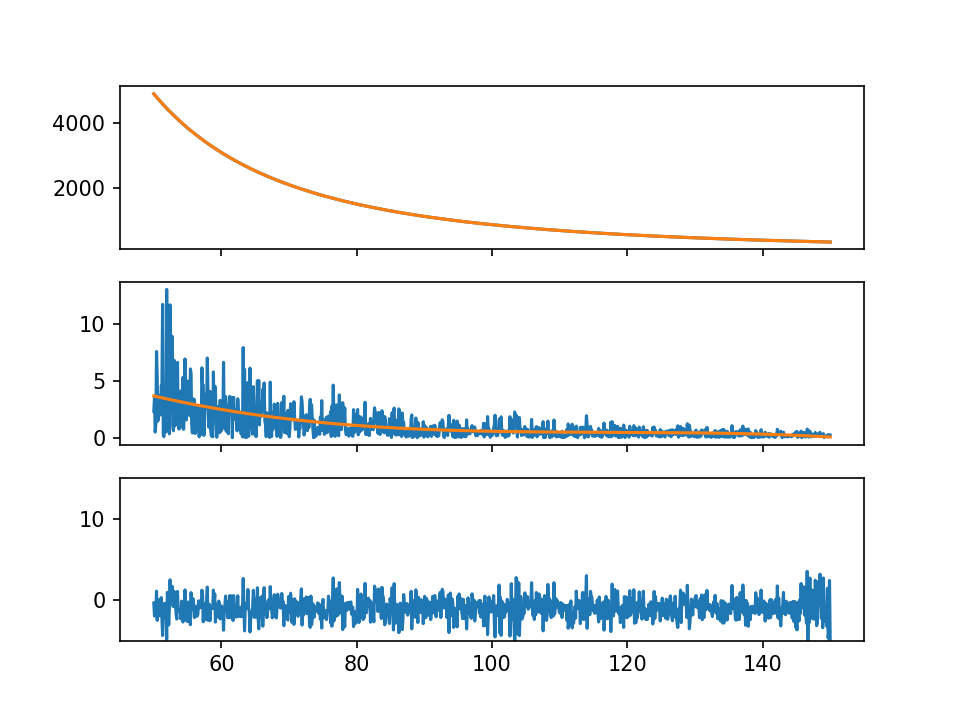

(-5, 15)

In [202]:
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(freq, sky)
ax[0].plot(freq, model)

ax[1].plot(freq, np.abs(res))
ax[1].plot(freq, model_std)

ax[2].plot(freq, res/model_std - 1)
ax[2].set_ylim((-5, 15))

### Flat / random

In [212]:
sky_model = np.ones(NFREQ)
rfi_model = np.zeros(NFREQ)
np.random.seed(12345)
rfi_model[np.random.randint(0, NFREQ, 40)] = 1

noise = thermal_noise(sky_model, scale=1000)
rfi = rfi_model * (sky_model/1000).max() * 200
sky = rfi + noise + sky_model
true_flags = rfi_model > 0

In [213]:
spectrum = sky
weights=None
f_ratio=None
f_log=False
t_log=True,
n_signal=2
n_resid=3
threshold=10
max_iter=20
accumulate=False
increase_order=True
min_threshold=5
decrement_threshold = 0
# ------------

if min_threshold > threshold:
    warnings.warn(f"You've set a threshold smaller than the min_threshold of {min_threshold}. Will use threshold={min_threshold}.")
    threshold = min_threshold

if f_log and not f_ratio:
    raise ValueError("If fitting in log(freq), you must provide f_ratio.")

assert threshold > 3

nf = spectrum.shape[-1]
orig_flags = np.zeros(nf, dtype=bool)
f = np.linspace(-1, 1, nf) if not f_log else np.logspace(0, f_ratio, nf)

orig_flags |= (spectrum <= 0) | np.isnan(spectrum) | np.isinf(spectrum)

if weights is not None:
    orig_flags |= weights <= 0

flags = orig_flags.copy()

if not increase_order:
    assert n_resid < n_signal

n_flags_changed = 1
counter = 0

while (
    n_flags_changed > 0
    and counter < max_iter
    and np.sum(~flags) > n_signal * 2
):
    ff = f[~flags]
    s = spectrum[~flags]

    if t_log:
        s = np.log(s)

    par = np.polyfit(ff, s, n_signal)
    model = np.polyval(par, f)

    if t_log:
        model = np.exp(model)

    res = spectrum - model

    par = np.polyfit(ff, np.abs(res[~flags]), n_resid if n_resid > 0 else n_signal + n_resid)
    model_std = np.polyval(par, f)

    if accumulate:
        nflags = np.sum(flags[~flags])
        flags[~flags] |= np.abs(res)[~flags] > threshold * model_std[~flags]
        n_flags_changed = np.sum(flags[~flags]) - nflags
    else:
        new_flags = orig_flags | (np.abs(res) > threshold * model_std)
        n_flags_changed = np.sum(flags ^ new_flags)
        flags = new_flags.copy()

    counter += 1
    if increase_order:
        n_signal += 1

    threshold = max(threshold - decrement_threshold, min_threshold)
    
    print(f"False positives after {counter+1} iters: ", np.sum(flags[~true_flags]))
    print(f"False negatives after {counter+1} iters: ", np.sum(~flags[true_flags]))
    

False positives after 2 iters:  0
False negatives after 2 iters:  11
False positives after 3 iters:  97
False negatives after 3 iters:  3
False positives after 4 iters:  289
False negatives after 4 iters:  0
False positives after 5 iters:  0
False negatives after 5 iters:  0
False positives after 6 iters:  0
False negatives after 6 iters:  0


<IPython.core.display.Javascript object>


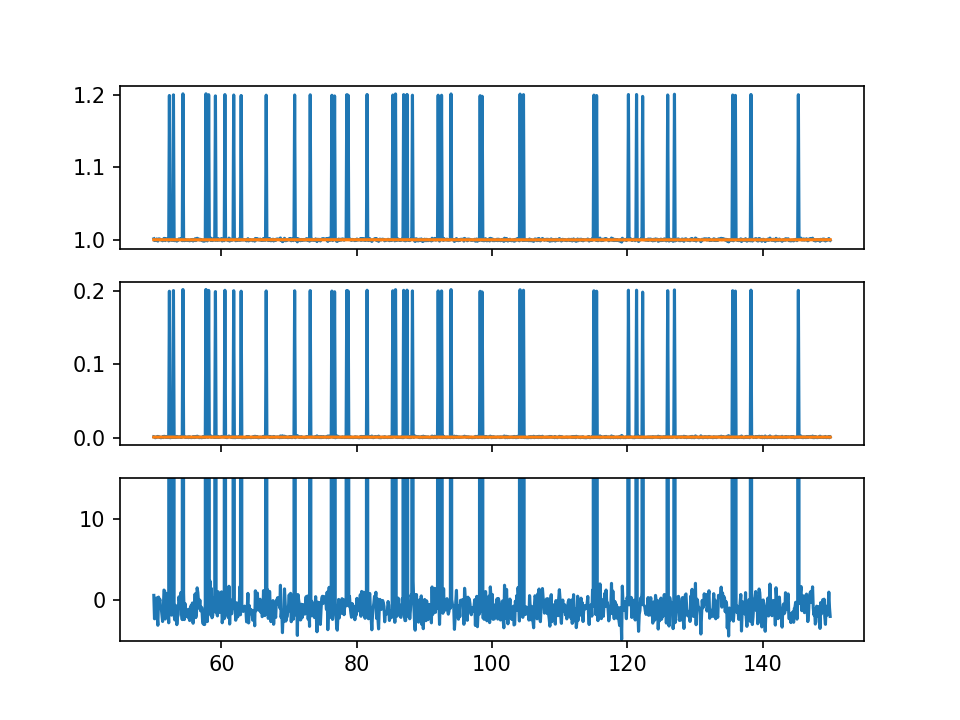

(-5, 15)

In [214]:
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(freq, sky)
ax[0].plot(freq, model)

ax[1].plot(freq, np.abs(res))
ax[1].plot(freq, model_std)

ax[2].plot(freq, res/model_std - 1)
ax[2].set_ylim((-5, 15))